In [143]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from src.helpers import *

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import math
import pickle
import itertools
import random
import json
import statistics
import copy

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from src.vcfs_parser import parser
from src.counts import count_snps
from src.msa_analysis import msa_parser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
based_on = [1, 2]

df = pd.read_csv('data/dataset.csv', index_col = 0, low_memory=False)
mut_cols = [col for col in df.columns.to_list() if col.isnumeric()]


lineages_of_interest = ['B.1.1.7','B.1.617.2','AY.12', 'AY.9', 'AY.4', 'B.1.1.318', 'AY.7']  # Lineages of interest
df = df.loc[df['lineage'].isin(lineages_of_interest)].copy()

lineages = df.loc[:,'lineage'].copy()
# cols.unique()
# cols[pd.isna(cols)] = 'unlabeled'

In [ ]:
for bo in based_on:
    print('Based on {}'.format(bo))
    X = prepare_for_clustering(df, mut_cols, based_on = bo)

    X_transformed = TSNE(n_components=2,\
                      init='random', n_jobs=-1).fit_transform(X)
    X_transformed.shape

    # kmeans = KMeans(n_clusters=20, random_state=0).fit(X_transformed)
    # kmeans.labels_

    dbscan = DBSCAN(eps = 5, n_jobs = -1).fit(X_transformed)
    dbscan.labels_
    df['cluster_' + str(bo)] = dbscan.labels_
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    n_noise_ = list(dbscan.labels_).count(-1)
    print('Estimated number of clusters', n_clusters_)
    print('Estimated number of noise', n_noise_)


    colors = [str(k) for k in dbscan.labels_.tolist()]
    centroids = np.zeros((len(set(dbscan.labels_)), 2))
    for i, label in enumerate(np.unique(dbscan.labels_)):
        msk = dbscan.labels_ == label
        points = [X_transformed[j,:] for j, value in enumerate(msk) if value]
        centroids[i] = np.mean(points, axis=0)




    palette = sns.color_palette("Paired") + sns.color_palette("Set3", 12)
    g = sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1], hue = colors, style=lineages)
    g.scatter(x = centroids[:,0], y=centroids[:,1], color='black', marker='+', s=16, linewidths=0.7)
    g.set_title('TSNE->DBSCAN on the bin matrix ' + str(bo) + 's')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.savefig('TSNE->DBSCAN on the bin matrix ' + str(bo) + 's_final.pdf', format='pdf', bbox_inches='tight')
    plt.clf()

In [ ]:
%%time
counter = count_snps(df, lineages_of_interest, based_on)
counter.occurences_of_mutations()

### Calculate nodes dataframe old method(one lineage), new method(multiple lineages)

In [ ]:
# %%time
# # ------------- old method -------------
# lineage = 'B.1.1.7'
# nodes = counter.clusters_intersection()
# # nodes = nodes.loc[(nodes['cluster_1'] == 4) & (nodes['cluster_2'] == 0)].copy()
# nodes['samples'] = nodes.apply(lambda x: x['samples'][lineage] if lineage in x['samples'] else np.nan, axis = 1)
# nodes.dropna(how = 'any', inplace = True)

# for bo in based_on:
#     bo = str(bo)
#     pos_columns = ["{lineage}_C{cluster}_pos_{bo}".format(lineage = lineage, cluster = k, bo = bo) for k in nodes['cluster_' + bo].tolist()]
#     count_columns = ["{lineage}_C{cluster}_counts_{bo}".format(lineage = lineage, cluster = k, bo = bo) for k in nodes['cluster_' + bo].tolist()]
#     nodes['based_on_' + bo + '_pos'] = remove_nan_from_list_of_lists( \
#                                             counter.counts.loc[:, pos_columns].values.T.tolist())
#     nodes['based_on_' + bo + '_counts'] = remove_nan_from_list_of_lists( \
#                                             counter.counts.loc[:, count_columns].values.T.tolist())
#     nodes['snps_on_' + bo] =  nodes.apply(lambda x: [counter.get_snps_from_lineages_clusters_position(x['samples'], \
#                                                  region = 'NC_045512.2', \
#                                                  position = int(k)) for k in x['based_on_' + bo + '_pos']], axis = 1)
# nodes

# pickle.dump(nodes, open("data/nodes", "wb"))
# # nodes = pickle.load(open("data/nodes", "rb"))

In [5]:
# %%time
# # ------------- new method for all lineages -------------

# nodes = counter.clusters_intersection()

# # nodes.dropna(how = 'any', inplace = True)

# for bo in based_on:
#     bo = str(bo)
#     column_pos = []
#     column_counts = []
#     column_snps = []
#     for i in nodes.index:
#         d_pos = {}
#         d_counts = {}
#         d_snps = {}
#         for lineage in nodes.loc[i, 'samples'].keys():
#             pos_col = "{lineage}_C{cluster}_pos_{bo}".format(lineage = lineage, cluster = nodes.loc[i, 'cluster_' + bo], bo = bo)
#             count_col = "{lineage}_C{cluster}_counts_{bo}".format(lineage = lineage, cluster = nodes.loc[i, 'cluster_' + bo], bo = bo)

            
#             d_pos[lineage] = remove_nan_from_list( \
#                                     counter.counts.loc[:, pos_col].values.tolist())
#             d_counts[lineage] = remove_nan_from_list( \
#                                     counter.counts.loc[:, count_col].values.tolist())
#             d_snps[lineage] = [counter.get_snps_from_lineages_clusters_position( \
#                                         nodes.loc[i, 'samples'][lineage], \
#                                         region = 'NC_045512.2', \
#                                         position = int(k)) for k in d_pos[lineage]]
            
#         column_pos.append(d_pos)
#         column_counts.append(d_counts)
#         column_snps.append(d_snps)
#         print(i, ' done!')

#     nodes['based_on_' + bo + '_pos'] = column_pos
#     nodes['based_on_' + bo + '_counts'] = column_counts
#     nodes['snps_on_' + bo] = column_snps

# pickle.dump(nodes, open("data/nodes_all", "wb"))
nodes = pickle.load(open("data/nodes_all", "rb"))
nodes

,cluster_1,cluster_2,samples,based_on_1_pos,based_on_1_counts,snps_on_1,based_on_2_pos,based_on_2_counts,snps_on_2
0,0,0,"{'B.1.1.7': ['V1000', 'V1012', 'V1110', 'V1115...","{'B.1.1.7': [21991.0, 21992.0, 14407.0, 16175....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(38, {'T/-': 38}), (38, {'A/-': 3...","{'B.1.1.7': [21764.0, 21765.0, 21766.0, 21767....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9...","{'B.1.1.7': [(38, {'T/-': 38}), (38, {'A/-': 3..."
1,1,0,"{'B.1.1.7': ['V1001', 'V1112', 'V1562', 'V1568...","{'B.1.1.7': [240.0, 11293.0, 28281.0, 28280.0,...","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(21, {'C/T': 21}), (21, {'T/-': 2...","{'B.1.1.7': [21764.0, 21765.0, 21766.0, 21767....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9...","{'B.1.1.7': [(21, {'T/-': 21}), (21, {'A/-': 2..."
2,2,0,"{'B.1.1.7': ['V1002', 'V1005', 'V1009', 'V1116...","{'B.1.1.7': [11292.0, 14407.0, 11291.0, 11293....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(299, {'T/-': 299}), (299, {'C/T'...","{'B.1.1.7': [21764.0, 21765.0, 21766.0, 21767....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9...","{'B.1.1.7': [(299, {'T/-': 299}), (299, {'A/-'..."
3,2,1,"{'B.1.1.7': ['V1422', 'V1453', 'V1455', 'V1464...","{'B.1.1.7': [11292.0, 14407.0, 11291.0, 11293....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(11, {'T/-': 11}), (11, {'C/T': 1...","{'B.1.1.7': [28976.0, 28110.0, 21764.0, 21765....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(11, {'C/T': 11}), (11, {'A/G': 1..."
4,2,4,"{'B.1.1.7': ['V1715', 'V1828', 'V1871', 'V1923...","{'B.1.1.7': [11292.0, 14407.0, 11291.0, 11293....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","{'B.1.1.7': [(8, {'T/-': 8}), (8, {'C/T': 8}),...","{'B.1.1.7': [23062.0, 23270.0, 23402.0, 28110....","{'B.1.1.7': [1.0, 1.0, 1.0, 1.0, 0.9375, 0.875...","{'B.1.1.7': [(8, {'A/T': 8}), (8, {'C/A': 8}),..."
...,...,...,...,...,...,...,...,...,...
58,29,7,"{'AY.9': ['V3499', 'V3503', 'V3505', 'V3529', ...","{'AY.9': [22032.0, 22791.0, 14407.0, 28247.0, ...","{'AY.9': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","{'AY.9': [(72, {'C/-': 72}), (72, {'C/T': 72})...","{'AY.9': [5183.0, 25468.0, 11417.0, 11513.0, 2...","{'AY.9': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","{'AY.9': [(72, {'C/T': 72}), (72, {'C/T': 72})..."
59,30,3,"{'B.1.617.2': ['V2467', 'V2706', 'V2888', 'V28...","{'B.1.617.2': [209.0, 14407.0, 16465.0, 240.0,...","{'B.1.617.2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","{'B.1.617.2': [(11, {'G/T': 11}), (11, {'C/T':...","{'B.1.617.2': [23402.0, 26766.0, 27751.0, 2763...","{'B.1.617.2': [0.9983579638752053, 0.995073891...","{'B.1.617.2': [(11, {'A/G': 11}), (11, {'T/C':..."
60,30,6,"{'AY.12': ['V3517', 'V3518', 'V3846', 'V3869',...","{'AY.12': [19219.0, 14342.0, 22030.0, 22029.0,...","{'AY.12': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","{'AY.12': [(7, {'C/T': 7}), (7, {'T/C': 7}), (...","{'AY.12': [26766.0, 22916.0, 22994.0, 23402.0,...","{'AY.12': [1.0, 1.0, 1.0, 1.0, 0.9961832061068...","{'AY.12': [(7, {'T/C': 7}), (7, {'T/G': 7}), (..."
61,31,5,"{'B.1.617.2': ['V2546', 'V2679', 'V2688', 'V26...","{'B.1.617.2': [16465.0, 22033.0, 15450.0, 209....","{'B.1.617.2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","{'B.1.617.2': [(23, {'C/T': 23}), (23, {'A/-':...","{'B.1.617.2': [23402.0, 26766.0, 27637.0, 2360...","{'B.1.617.2': [0.9945205479452055, 0.989041095...","{'B.1.617.2': [(23, {'A/G': 23}), (23, {'T/C':..."


In [ ]:
for i in nodes.index:
    counts = {}
    samples_dict = nodes.loc[i, 'samples']
    for key, value in samples_dict.items():
        increase_value_of_dict_by_value_new(counts, key, len(value))
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    (labels, sizes) = zip(*counts.items())
    #     labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
    #     sizes = [15, 30, 45, 10]
    #     explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.axis('tight')
    ax1.axis('off')
#     fig1.set_size_inches(10, 10)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90, labeldistance = None, rotatelabels = True,
               wedgeprops={"edgecolor":"0",'linewidth': 0})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.savefig('data/circular_images/{}.png'.format(i), transparent=True, bbox_inches='tight', pad_inches = 0)
    plt.clf()
    plt.close()
#     break

### Calculate fully connected graph edges old method(one lineage), new method(multiple lineages)

In [ ]:
# # ------------- old ---------------
# threshold = 1
# edges = []
# j_loop_indecies = nodes.index.tolist()
# # test = []
# for i in nodes.index:
#     j_loop_indecies.remove(i)

#     pos_i_dict = list_to_index_val_dict(nodes.loc[i, 'based_on_1_pos'] + nodes.loc[i, 'based_on_2_pos'])
#     counts_i = nodes.loc[i, 'based_on_1_counts'] + nodes.loc[i, 'based_on_2_counts']
# #     print(pos_i_dict)
#     for j in j_loop_indecies:
#         pos_j_dict = list_to_index_val_dict(nodes.loc[j, 'based_on_1_pos'] + nodes.loc[j, 'based_on_2_pos'])
#         counts_j = nodes.loc[j, 'based_on_1_counts'] + nodes.loc[j, 'based_on_2_counts']
# #         print(pos_j_dict)
#         d = {}
#         intersection = list(set(pos_i_dict) & set(pos_j_dict))
#         for inter in intersection:
# #             test.append((pos_i_dict[inter], pos_j_dict[inter]))
# #             d[inter] = ((pos_i_dict[inter], get_list_items_from_idx_list(counts_i, pos_i_dict[inter])), 
# #                         (pos_j_dict[inter], get_list_items_from_idx_list(counts_j, pos_j_dict[inter])))
#             d[str(int(inter))] = min(get_list_items_from_idx_list(counts_i, pos_i_dict[inter]) + 
#                            get_list_items_from_idx_list(counts_j, pos_j_dict[inter]))
        
#         keys_to_be_deleted = []
#         for key, value in d.items():
#             if value < threshold:
#                 keys_to_be_deleted.append(key)
#         for key in keys_to_be_deleted:
#             d.pop(key)
#         if not d:
#             print('Empty')
#         title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['weights']) \
#                             .reset_index() \
#                             .rename(columns = {'index':'position'}) \
#                             .to_html(index = False)
#         edges.append((i, j, {'weights' : d,
#                              'weight' : len(d),
#                              'value' : len(d),
#                              'title' : title}))
# #         print(d)
# #         break
# #     break

In [ ]:
# ------------- new ---------------
threshold = 1
edges = []
j_loop_indecies = nodes.index.tolist()
# test = []
for i in nodes.index:
    j_loop_indecies.remove(i)

    keys_i = nodes.loc[i, 'samples'].keys()
    
    for key_i in keys_i:
        pos_i_dict = list_to_index_val_dict(nodes.loc[i, 'based_on_1_pos'][key_i] + nodes.loc[i, 'based_on_2_pos'][key_i])
        counts_i = nodes.loc[i, 'based_on_1_counts'][key_i] + nodes.loc[i, 'based_on_2_counts'][key_i]
    #     print(pos_i_dict)
        for j in j_loop_indecies:
            for key_j in nodes.loc[j, 'samples']:
                pos_j_dict = list_to_index_val_dict(nodes.loc[j, 'based_on_1_pos'][key_j] + nodes.loc[j, 'based_on_2_pos'][key_j])
                counts_j = nodes.loc[j, 'based_on_1_counts'][key_j] + nodes.loc[j, 'based_on_2_counts'][key_j]
        #         print(pos_j_dict)
                d = {}
                intersection = list(set(pos_i_dict) & set(pos_j_dict))
                for inter in intersection:
                    d[str(int(inter))] = min(get_list_items_from_idx_list(counts_i, pos_i_dict[inter]) + 
                                             get_list_items_from_idx_list(counts_j, pos_j_dict[inter]))

                keys_to_be_deleted = []
                for key, value in d.items():
                    if value < threshold:
                        keys_to_be_deleted.append(key)
                for key in keys_to_be_deleted:
                    d.pop(key)
                if d:
                    (pos, min_weight) = zip(*d.items())
                    length = len(pos)
                    _from = [key_i] * length
                    _to = [key_j] * length

                    if len(pos) == len(min_weight) == len(_from) == len(_to):
                        title = pd.DataFrame.from_records(zip(_from, _to, pos, min_weight), columns = ['from', 'to', 'position', 'weights']).to_html(index = False)
                        edges.append((i, j, {'weights' : d,
                                             'value' : len(d),
                                             'title' : title}))
                    else:
                        print('Something went wrong with the lengths')
        #         print(d)
        #         break
        #     break

In [ ]:
from scipy.stats import norm
Q = 400
cols = {
    'from' : [],
    'to' : [],
    'weight' : []
}
for edge in edges:
    cols['from'].append(edge[0])
    cols['to'].append(edge[1])
    cols['weight'].append(edge[2]['value'])
    
x = cols['weight']
_std = statistics.pstdev(cols['weight'])
_mean = statistics.mean(cols['weight'])
_min = min(cols['weight'])
_max = max(cols['weight'])
# cols['weight'] = [((w - _min) / (_max - _min)) * Q  for w in cols['weight']]
cols['weight'] = [(w - _mean) / _std for w in cols['weight']]
cols['weight'] = norm.cdf(cols['weight'], loc=0, scale=0.04) * Q
pd.DataFrame.from_dict(cols).to_csv('data/fully-connected-graph.csv', header = False, index = False, sep = " ")
x = cols['weight']
plt.scatter(range(len(x)), x)

plt.title('How to calculate and plot a cumulative distribution function ?')

plt.show()

In [ ]:
!mcl data/fully-connected-graph.csv --abc -I 30 -scheme 7 -o data/fully-connected-graph-clusters.out
# !mcxload -abc data/fully-connected-graph.csv --stream-mirror -write-tab data.tab -o data/fully-connected-graph.mci
# !mcxi /data/fully-connected-graph.mci lm tp -1 mul add /data/check wm
# !mcxdump -imx data/data/check -tab data.tab --dump-table

### Calculate arrow edges old method(one lineage), new method(multiple lineages)

In [ ]:
# -----------------old-----------------
# edges = []

# for bo in based_on:
#     fo = str(based_on[~based_on.index(bo)])
#     bo = str(bo)
#     for i in nodes.index:


#         pos_i = nodes.loc[i, 'based_on_' + bo + '_pos']

#         same_clusters = nodes.loc[(nodes['cluster_' + bo] == nodes.loc[i, 'cluster_' + bo]) & \
#                                   (nodes['cluster_' + fo] != nodes.loc[i, 'cluster_' + fo]), :]

#         if not same_clusters.empty:
#     #             print(same_clusters[['cluster_1', 'cluster_2']])
#             for j in same_clusters.index:
#                 d = {}
#                 for l, snp_i in enumerate(nodes.loc[i, 'snps_on_'+ bo]):
#                     if snp_i[0] == 0:
#                         pos_j = same_clusters.loc[j, 'based_on_' + bo + '_pos']

#                         for k, snp_j in enumerate(same_clusters.loc[j, 'snps_on_'+ bo]):
#                             if (snp_j[0] > 0) and (pos_j[k] == pos_i[l]):
#     #                                 print('on {bo} empty pos {pos_i} of clust {i} -> {pos_j} of clust {j}'.format(bo = bo, pos_i = pos_i[l], pos_j = pos_j[k], i = i, j = j))
#                                 d[pos_i[l]] = (snp_i, snp_j)
#             if d:
#                 title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['from', 'to']) \
#                             .reset_index() \
#                             .rename(columns = {'index':'position'}) \
#                             .to_html(index = False)
#                 edges.append((i, j, {'color' : 'blue' if bo == "1" else 'red',
#                                      'arrows' : 'to',
#                                      'data' : d, 
#                                      'title' : title}))

In [6]:
# -----------------new-----------------
edges = []
for bo in based_on:
    fo = str(based_on[~based_on.index(bo)])
    bo = str(bo)
    for i in nodes.index:


        pos_i = flatten_list_of_lists(list(nodes.loc[i, 'based_on_' + bo + '_pos'].values()))

        same_clusters = nodes.loc[(nodes['cluster_' + bo] == nodes.loc[i, 'cluster_' + bo]) & \
                                  (nodes['cluster_' + fo] != nodes.loc[i, 'cluster_' + fo]), :]
        # if bo == '2' and i == 10:
        #     print(same_clusters)
        if not same_clusters.empty:
    #             print(same_clusters[['cluster_1', 'cluster_2']])
            for j in same_clusters.index:
                d = {}
                i_snps = flatten_list_of_lists(list(nodes.loc[i, 'snps_on_'+ bo].values()))
                for l, snp_i in enumerate(i_snps):
                    if snp_i[0] == 0:
                        pos_j = flatten_list_of_lists(list(same_clusters.loc[j, 'based_on_' + bo + '_pos'].values()))
                        j_snps = flatten_list_of_lists(list(same_clusters.loc[j, 'snps_on_'+ bo].values()))
                        
                        for k, snp_j in enumerate(j_snps):
                            if (snp_j[0] > 0) and (pos_j[k] == pos_i[l]):
                                # if bo == '2' and i == 10 and j == 9:
                                #     print('on {bo} empty pos {pos_i} of node {i} -> {pos_j} of node {j}'.format(bo = bo, pos_i = pos_i[l], pos_j = pos_j[k], i = i, j = j))
                                d[pos_i[l]] = (snp_i, snp_j)
            if d:
                title = pd.DataFrame.from_dict(d, orient = 'index', columns = ['from', 'to']) \
                            .reset_index() \
                            .rename(columns = {'index':'position'}) \
                            .to_html(index = False)
                edges.append((i, j, {'color' : 'blue' if bo == "1" else 'red',
                                     'arrows' : 'to',
                                     'data' : d, 
                                     'title' : title
                                    }))

### Initiate graph old method(one lineage), new method(multiple lineages)

In [ ]:
#-------------------old--------------
# G = nx.DiGraph(name = lineage)
# G.add_nodes_from(list(nodes.to_dict(orient='index').items()))


# G.add_edges_from(edges)


# net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True, directed = True, heading = G.name)

# net.from_nx(G)
# for i in range(len(net.nodes)):
#     pos = []
#     snps = []
#     index = []
#     total = []
#     f = []
# #     total_len = 0
#     for bo in based_on:
#         bo = str(bo)
        
#         pos = extend_list(pos, [int(k) for k in net.nodes[i]['based_on_{}_pos'.format(bo)]])
#         f = extend_list(f, ["{:.2f}".format(k) for k in net.nodes[i]['based_on_{}_counts'.format(bo)]])
#         length = len(pos)
#         index = extend_list(index, [bo] * length)
        
#         total = extend_list(total, [k[0] for k in net.nodes[i]['snps_on_{}'.format(bo)]])
#         snps = extend_list(snps, [str(k[1]) for k in net.nodes[i]['snps_on_{}'.format(bo)]])
    
#     print(len(pos))
#     print(len(index))
#     net.nodes[i]['title'] = pd.DataFrame.from_records(zip(index, pos, f, total, snps), columns = ['Based_on','Position', 'f', 'Total', 'Snps']).to_html(index = False) 
# #         total_len = total_len + length 
# #     net.nodes[i]['label'] = total_len

# # net.show('example3.html')

In [ ]:
arrow_edges = {}

for edge in edges:
    if edge[0] not in arrow_edges:
        arrow_edges[edge[0]] = [(edge[1], edge[2]['color'])]
    else:
        if (edge[1], edge[2]['color']) not in arrow_edges[edge[0]]:
            arrow_edges[edge[0]].append((edge[1], edge[2]['color']))

arrow_edges

In [ ]:
#-------------------new--------------
d = pd.read_csv('data/fully-connected-graph-clusters.out', sep='\t', header = None).T.to_dict(orient='list')
d = remove_nan_from_dict_of_lists(d)
d = int_dict_of_lists(d)
groups = {}
for key, value in d.items():
    for element in value:
        groups[element] = key

nodes['id'] = nodes.index
        
G = nx.DiGraph(name = lineages_of_interest)
G.add_nodes_from(list(nodes.to_dict(orient='index').items()))


G.add_edges_from(edges)

net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True, directed = True, heading = " ".join(str(x) for x in G.name))
net.set_options(json.dumps({
    "configure": {
        "enabled": False
    },
    "nodes":{
        "borderWidth": 10,
        "borderWidthSelected": 10,
        "size": 400,
        "chosen": True,
        "font": {
            "size": 11,
        }
    },
    "edges": {
        "scaling": {
            "min": 0.1,
            "max": 1,
        },
        "selectionWidth" : 0,
        "color": {
            "inherit": False
        },
        "smooth": {
            "enabled": False,
            "type": "continuous"
        }
    },
    "interaction": {
        "dragNodes": True,
        "hideEdgesOnDrag": False,
        "hideNodesOnDrag": False
    },
    "physics": {
        "enabled": False,
    },
    "layout": {
        "randomSeed": 100,
    }
}))

net.from_nx(G)
for i in range(len(net.nodes)):
    pos = []
    snps = []
    index = []
    total = []
    lineage = []
    f = []
#     total_len = 0
    for bo in based_on:
        for lin in net.nodes[i]['based_on_{}_pos'.format(bo)].keys():
            bo = str(bo)

            pos = extend_list(pos, [int(k) for k in net.nodes[i]['based_on_{}_pos'.format(bo)][lin]])
            f = extend_list(f, ["{:.2f}".format(k) for k in net.nodes[i]['based_on_{}_counts'.format(bo)][lin]])
            
            length = len(net.nodes[i]['based_on_{}_pos'.format(bo)][lin])
            index = extend_list(index, [bo] * length)
            lineage = extend_list(lineage, [lin] * length)


            total = extend_list(total, [k[0] for k in net.nodes[i]['snps_on_{}'.format(bo)][lin]])
            snps = extend_list(snps, [str(k[1]) for k in net.nodes[i]['snps_on_{}'.format(bo)][lin]])
            
    if len(index) == len(lineage) == len(pos) == len(f) == len(total) == len(snps):
        net.nodes[i]['title'] = pd.DataFrame.from_records(zip(index, lineage, pos, f, total, snps), columns = ['Based_on', 'Lineage', 'Position', 'f', 'Total', 'Snps']).to_html(index = False) 
    #     total_len = total_len + length 
        net.nodes[i]['label'] = " ".join(str(x) for x in list(set(lineage))) + '\n' + str(net.nodes[i]['id'])
        net.nodes[i]['group'] = groups[net.nodes[i]['id']]
        net.nodes[i]['shape'] = "circularImage"
        net.nodes[i]['image'] = "data/circular_images/{}.png".format(net.nodes[i]['id'])
#         net.nodes[i]['color'] = 'black'
    else:
        print('Something went wrong with the lengths')

net.show('example7.html')

In [ ]:
centrality = nx.algorithms.centrality.degree_centrality(G)
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(G)
load_centrality =  nx.algorithms.centrality.load_centrality(G)

list_of_nodes = list(G.nodes())

paths = []
for node in list_of_nodes:
    temp = copy.deepcopy(list_of_nodes)
    temp.pop(temp.index(node))
    paths.extend(list(nx.algorithms.simple_paths.all_simple_paths(G, source = node, target = temp)))

In [ ]:
cluster_1 = []
cluster_2 = []
position = []
f = []
snps = []
based = []
node = []
from_node = []
to_node = []
lineage = []
mcl_group = []
central = []
bet_central = []
l_central = []


for bo in based_on:
    for i in nodes.index:
        line = nodes.loc[i, :]
        for key, value in line["based_on_{}_pos".format(bo)].items():
            
            position = extend_list(position, [int(k) for k in value])
            f = extend_list(f, line["based_on_{}_counts".format(bo)][key])
            snps = extend_list(snps, line["snps_on_{}".format(bo)][key])
            
            length = len(line["based_on_{}_pos".format(bo)][key])
            
            lineage = extend_list(lineage, [key] * length)
            based = extend_list(based, [bo] * length)
            
            node = extend_list(node, [i] * length)
            mcl_group = extend_list(mcl_group, [groups[i]] * length)
            central = extend_list(central, [centrality[i]] * length)
            bet_central = extend_list(bet_central, [betweenness_centrality[i]] * length)
            l_central = extend_list(l_central, [load_centrality[i]] * length)
            
            
            cluster_1 = extend_list(cluster_1, [line['cluster_1']] * length)
            cluster_2 = extend_list(cluster_2, [line['cluster_2']] * length)

#         break
#     break

if check_if_lists_in_list_have_same_length([position, \
                                            f, \
                                            snps, \
                                            lineage, \
                                            based, \
                                            node, \
                                            mcl_group, \
                                            central, \
                                            bet_central, \
                                            l_central, \
                                            cluster_1, \
                                            cluster_2]):
    result_long = pd.DataFrame.from_records(zip(position, f, snps, lineage, based, cluster_1, cluster_2, node, mcl_group, central, bet_central, l_central), \
                                            columns = ['position', 'f', 'snps', 'lineage', 'based_on', 'cluster_1', 'cluster_2',\
                                                       'node', 'mcl_group', 'central', 'bet_central', 'l_central'])
result_long

In [ ]:
df['collection date']
nodes
x = []
y = []
lin = []
cdict = {'B.1.1.7' : 'red', 
         'B.1.617.2' : 'blue',
         'AY.12' : 'green',
         'AY.9' : 'yellow',
         'AY.4' : 'purple',
         'B.1.1.318': 'brown',
         'AY.7' : 'black'}
for i in nodes.index:
    for j, val in nodes.loc[i, 'samples'].items():
        length = len(val)
        lin = extend_list(lin, [j] * length)
        x = extend_list(x, [i] * length)
        y = extend_list(y, df.loc[val, 'collection date'].tolist())

y = [np.nan if d == 'not provided' else d for d in y]
dates = pd.DataFrame.from_records(zip(y, x, lin), columns = ['dates', 'nodes', 'lineage'])
dates.dropna(how = 'any')
dates['dates'] =  pd.to_datetime(dates['dates'])



fig, ax = plt.subplots()
for lineage in dates['lineage'].unique():
    x = dates.loc[dates['lineage'] == lineage, 'nodes']
    y = dates.loc[dates['lineage'] == lineage, 'dates']
    
    ax.scatter(x, y, c=cdict[lineage], label=lineage)

ax.set_ylabel('Collection date')
ax.set_xlabel('Nodes')
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
nodes.index

In [ ]:
for i in nodes.index:
    for edge in edges:
        if edge[0] == i or edge[0] == i:
            print(edge[0], edge[1], edge[2]['color'])

In [86]:
names = []
seqs = []
lengths = []
uniques = []
for seq_record in SeqIO.parse("data/combined-MSA-keep_length_ep0.1.fasta", "fasta"):
    names.append(seq_record.id)
    seqs.append(str(seq_record.seq))
    uniques.append(list(set(str(seq_record.seq))))
    lengths.append(len(seq_record))

In [120]:
nodes_of_interest = [23,42,32,14,15,3,16,25,24,2,4,5,33,38,35,61]
# nodes_of_interest = [55,45,44]
# nodes_of_interest = [37,58,56,62]
# nodes_of_interest = [2,4,5,61]

permutations_of_nodes_of_interest = list(itertools.permutations(nodes_of_interest, 2))

tmp = []
for i in nodes.loc[nodes_of_interest, 'samples']:
    tmp.append(list(i.values()))

samples = list(set(flatten_list_of_lists(flatten_list_of_lists(tmp))))
prefix_samples = add_prefix_to_list_of_strings(samples, 'New|1_')
msa_indices = flatten_list_of_lists(search_elements_in_list(names, prefix_samples))

sequences = get_list_items_from_idx_list(seqs, msa_indices)
sequences_names = get_list_items_from_idx_list(names, msa_indices)

record_list = []
for (name, seq_string) in zip(sequences_names, sequences):
    record = SeqRecord(Seq(seq_string), id=name, description="")
    record_list.append(record)

SeqIO.write(record_list, "data/example_msa.fasta", "fasta")
msa = msa_parser("data/example_msa.fasta")

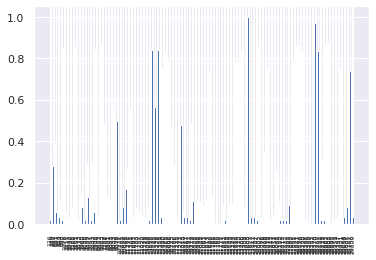

  0%|          | 0/200 [00:00<?, ?it/s]

In [125]:
msa.calculate_probabilities()
indices_of_pos_with_length_of_probs_larger_than_1 = [idx for idx, value in enumerate(msa.probabilities) if len(value) > 1]

# retrive edges mutations of the nodes of interest
edges_of_interest = search_in_edges(edges, permutations_of_nodes_of_interest)
edges_data = list(set([int(i) for i in flatten_list_of_lists([list(k[2]['data'].keys()) for k in edges_of_interest])]))

msa.probabilities = get_list_items_from_idx_list(msa.probabilities, edges_data)
### ara theloume mono tis theses poy de;ixnoyn ta arrows na ta psaxnoume sto msa kai na ypologizoume tis entropies giati
### giati endiaferomaste mono gia ekeines tis theses pou aforoun tha katallhla zeygaria clusters kai OXi gia oles tis theseis
### pou fainontai metalagmenes sto MSA metaksy twn samples of interest


# ## sort the probabilities based on the positions (edge_data) in an asceding order
# sorted_probabilities = [x for _, x in sorted(zip(edges_data, msa.probabilities), key=lambda pair: pair[0])]
# sorted_edge_data = sorted(edges_data)

# ([(ind,prob) for ind,prob in zip(sorted(edges_data), sorted_probabilities)])
msa.calculate_entropies()

## sort the entropies based on the positions (edge_data) in an asceding order
sorted_entropies = [x for _, x in sorted(zip(edges_data, msa.entropies), key=lambda pair: pair[0])]
sorted_edge_data = sorted(edges_data)
sorted_edge_data_frequencies = {}

for i in sorted_edge_data:
    d = df.loc[samples, str(i)].value_counts(normalize = True).to_dict()
    dd = {}
    for key, value in d.items():
        if key == 2:
            dd['chr'] = value * 100
        elif key == 1:
            dd['non-chr'] = value * 100
            
    sorted_edge_data_frequencies[i] = dd

plt.bar([str(k) for k in sorted_edge_data], sorted_entropies)
plt.xticks(rotation=90, fontsize=6)
plt.savefig('mutual_info-entropy/entropies-nodes_{}.pdf'.format('-'.join([str(k) for k in nodes_of_interest])))
plt.show()

msa.calculate_mutual_info(array = msa.transposed_array_of_sequences[sorted_edge_data, :])

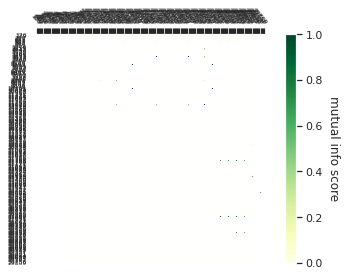

In [126]:
fig, ax = plt.subplots()
# ax.set_title(' | '.join([k.split('_')[1] for k in sequences_names]))

im, cbar = heatmap(msa.mutual_info, sorted_edge_data, sorted_edge_data, ax=ax,
                   cmap="YlGn", cbarlabel="mutual info score", interpolation='none')
# texts = annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=6)

fig.tight_layout()
plt.savefig('mutual_info-entropy/mutual_info-nodes_{}.pdf'.format('-'.join([str(k) for k in nodes_of_interest])))
plt.show()

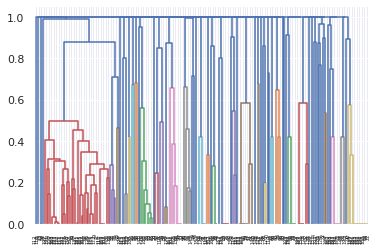

In [127]:
from sklearn.cluster import AgglomerativeClustering

similarity = 1 - msa.mutual_info

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed', linkage='complete')

model = model.fit(similarity)
# plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=100)#, labels=sorted_edge_data)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('mutual_info-entropy/h-clustering-nodes_{}.pdf'.format('-'.join([str(k) for k in nodes_of_interest])))
plt.show()

In [149]:
wierd_chars = ['†', 'ψ', '⛥', '✠', 'ɸ', '♣', '▲']
lineages_to_chars = {k : wierd_chars[i] for i, k in enumerate(lineages_of_interest)}
sorted_edge_metadata = []
for i in sorted_edge_data:
    lins = df.loc[df[str(i)] == 2, 'lineage'].unique().tolist()
    if lins:
        tmp = []
        for j in lins:
            tmp.append(lineages_to_chars[j])
        sorted_edge_metadata.append(" ".join(tmp))
    else:
        sorted_edge_metadata.append("")

with open("../tree-of-life/files/life.json", "w") as write_file:
    labels = []
    for i, k in enumerate(sorted_edge_data):
        chr_f = sorted_edge_data_frequencies[k].get('chr', '')
        non_chr_f = sorted_edge_data_frequencies[k].get('non-chr', '')
        
        pos_color = 'black'
        if non_chr_f != '' and chr_f == '' and non_chr_f <= 5:
            pos_color = '#BABABA'
        
        labels.append(
            {'pos' : {'value' : str(k), 'color' : pos_color},
             'symbols' : {'value' : sorted_edge_metadata[i], 'color' : 'green'},
             'freqs' : {'chr' : {'value' : check_if_frequency_is_empty(chr_f), 'color' : 'red'},
                        'non_chr' : {'value' : check_if_frequency_is_empty(non_chr_f), 'color' : 'blue'}
                       }
            }
        )
    json.dump(model_tree_to_nested_dics(model, labels), write_file, indent = 4)

<AxesSubplot:ylabel='geographic location (region and locality)'>

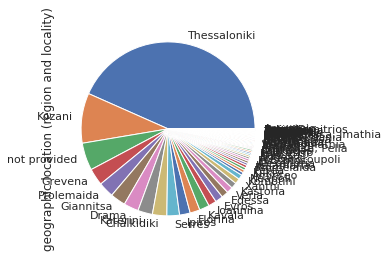

In [288]:
# df.loc[:, ['geographic location (region and locality)', 'geographic location (country and/or sea)']]

# pd.unique(df['geographic location (region and locality)'])

df['geographic location (region and locality)'].value_counts().plot(kind='pie')

# df.plot.pie(y='geographic location (region and locality)', figsize=(5, 5))